<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-5--predicting-future-friendships/02_dynamic_graph_theory_and_social_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dynamic graph theory for node ranking and social network analysis

Network theory is the study of connections between objects. These objects can be
anything: 

* people connected by relationships, 
* web pages connected by web links, or
* cities connected by roads. 

A collection of objects and their dispersed connections is
called either a network or a graph, depending on whom you ask. 

Engineers prefer to use the term network, while mathematicians prefer graph.

Graphs are simple abstractions that
capture the complexity of our entangled, interconnected world. 

Properties of graphs
remain surprisingly consistent across systems in society and nature.

Graph theory is a
framework for mathematically tracking these consistencies. It combines ideas from diverse branches of mathematics, including probability theory and matrix analysis.

These ideas can be used to gain useful real-world insights ranging from:

* search engine page rankings 
* social circle clustering

So some knowledge of graph theory is indispensable to doing good data science.

##Setup

In [ ]:
!pip install networkx
!pip install markov_clustering

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import re
import glob
import time
import numpy as np
import pandas as pd

import networkx as nx
from markov_clustering import get_clusters, run_mcl

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

##Modeling complex network

In [4]:
# Modeling five towns in the same county
G = nx.Graph()
G.add_nodes_from((i, {"county_id": 0}) for i in range(5))

In [5]:
# Modeling random intra-county roads
def add_random_edge(G, node1, node2, prob_road=.9, mean_drive_time=20):
  # Flips a coin to determine whether an edge is inserted
  if np.random.binomial(1, prob_road):
    # Chooses the travel time from a normal distribution  
    drive_time = np.random.normal(mean_drive_time)
    G.add_edge(node1, node2, travel_time=round(drive_time, 2))

def random_county(county_id):
  # Chooses the number of towns in the county at random from an integer range of 3 to 10
  num_towns = np.random.randint(3, 10)
  G = nx.Graph()
  nodes = [(node_id, {"county_id": county_id}) for node_id in range(num_towns)]
  G.add_nodes_from(nodes)
  for node1, _ in nodes[:-1]:
    for node2, _ in nodes[node1 + 1:]:
      add_random_edge(G, node1, node2)
  return G

def add_intercounty_edges(G):
  nodes = list(G.nodes(data=True))
  # Iterates over every node and Iterates over every node and
  for node1, attributes1 in nodes[:-1]:
    county1 = attributes1["county_id"]
    # Iterates over node pairs that we have not yet compared
    for node2, attributes2 in nodes[node1:]:
      if county1 != attributes2["county_id"]:
        add_random_edge(G, node1, node2, prob_road=0.05, mean_drive_time=45)
  return G

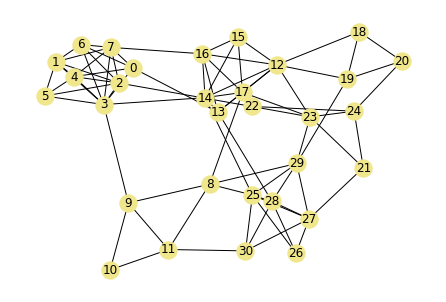

In [6]:
# Simulating six interconnected counties
np.random.seed(1)

G = random_county(0)
for county_id in range(1, 6):
  G2 = random_county(county_id)
  G = nx.disjoint_union(G, G2) 

G = add_intercounty_edges(G)
np.random.seed(1)
nx.draw(G, with_labels=True, node_color="khaki")
plt.show()

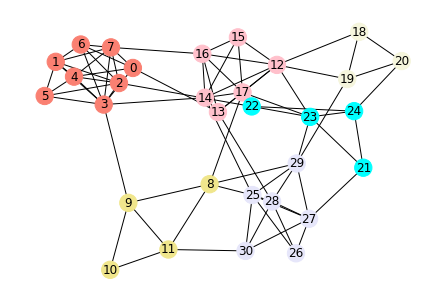

In [7]:
# Coloring nodes by county
np.random.seed(1)

county_colors = ['salmon', 'khaki', 'pink', 'beige', 'cyan', 'lavender']
county_ids = [G.nodes[n]["county_id"] for n in G.nodes]
node_colors = [county_colors[id_] for id_ in county_ids] 

nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

##Uncovering central nodes

Suppose our business is growing at an impressive rate. We wish to expand our customer
base by putting up a billboard advertisement in one of the local towns represented
by `G.nodes`. 

To maximize billboard views, we’ll choose the town with the
heaviest traffic.

Using simple modeling, we can predict traffic flow from the
network of roads between the towns.

We can compute the degree of any node i by summing over the ith column of the
graph’s adjacency matrix, or we can measure the degree by running `len(G.nodes[i])`.

In [8]:
# Computing the degree of a single node
adjacency_matrix = nx.to_numpy_array(G)
degree_town_0 = adjacency_matrix[:, 0].sum()
assert degree_town_0 == len(G[0])
assert degree_town_0 == G.degree(0)

print(f"Town 0 is connected by {degree_town_0:.0f} roads.")

Town 0 is connected by 5 roads.


Using their degrees, we rank our nodes based on importance. 

In graph theory, any
measure of a node’s importance is commonly called node centrality, and ranked importance
based on a node’s degree is called the degree of centrality. 

We now select the node
with the highest degree of centrality in G: this central node will serve as our initial
choice for the billboard’s location.

Town 3 is our most central town. It has 9 connecting roads.


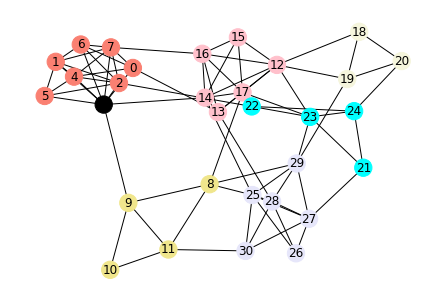

In [9]:
# Selecting a central node using degree of centrality
np.random.seed(1)

central_town = adjacency_matrix.sum(axis=0).argmax()
degree = G.degree(central_town)
print(f"Town {central_town} is our most central town. It has {degree} connecting roads.")

node_colors[central_town] = "k"
nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

In [10]:
# Selecting a node with the second-highest degree of centrality
second_town = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)[1]
second_degree = G.degree(second_town)
print(f"Town {second_town} has {second_degree} connecting roads.")

Town 12 has 8 connecting roads.


What would we do if these two towns had equal degrees? 

Let’s challenge ourselves to find out.

Suppose that road is closed due to disrepair. That closure necessitates the removal of an edge in G.


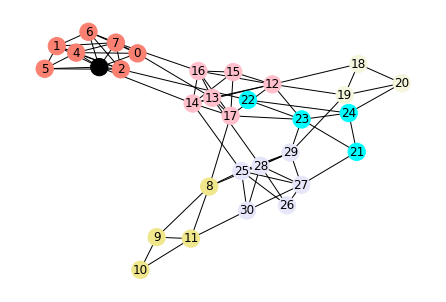

In [11]:
# Removing an edge from the most central node
np.random.seed(1)

G.remove_edge(3, 9)
# After edge deletion, Towns 3 and 12 share the same degree of centrality
assert G.degree(3) == G.degree(12)

nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

Town 3 is now less central than Town 12, but the degrees of both towns are equal.

We’ve exposed a significant flaw of the degree of centrality: connecting roads don’t matter if they don’t lead anywhere important.

###Measuring nodes centrality

We’ll shortly simulate traffic in our network by having 20,000 simulated cars drive randomly
around our 31 towns. 

However, first we need to simulate the random path of a
single car.

>In graph theory, this type of random traversal between nodes is called
a random walk.

In [12]:
# Simulating the random route of a single car
np.random.seed(0)

def random_drive(num_stops=10):
  # The car’s starting location is chosen at random
  town = np.random.choice(G.nodes)
  for _ in range(num_stops):
    # The car drives to a random neighboring town
    town = np.random.choice(G[town])
  return town

In [13]:
destination = random_drive()
print(f"After driving randomly, the car has reached Town {destination}.")

After driving randomly, the car has reached Town 24.


In [14]:
# Simulating traffic using 20,000 cars
np.random.seed(0)

car_counts = np.zeros(len(G.nodes))
num_cars = 20000

start_time = time.time()

for _ in range(num_cars):
  destination = random_drive()
  car_counts[destination] += 1

central_town = car_counts.argmax()
traffic = car_counts[central_town]
running_time = time.time() - start_time

print(f"We ran a {running_time:.2f} second simulation.")
print(f"Town {central_town} has the most traffic.")
print(f"There are {traffic:.0f} cars in that town.")

We ran a 5.13 second simulation.
Town 12 has the most traffic.
There are 1015 cars in that town.


This is not surprising, given that
Town 12 and Town 3 share the highest degree of centrality. 

Based on our previous discussion,
we also expect Town 12 to have heavier traffic than Town 3.

In [15]:
# Checking the traffic in Town 3
print(f"There are {car_counts[3]:.0f} cars in Town 3.")

There are 934 cars in Town 3.


Our expectations are verified. Town 3 has fewer than 1000 cars. 

We should note that
car counts can be cumbersome to compare, especially when `num_cars` is large. 

Hence, it’s preferable to replace these direct counts with probabilities through division by the
simulation count.

In [16]:
# Converting traffic counts to probabilities
probabilities = car_counts / num_cars

for i in [12, 3]:
  prob = probabilities[i]
  print(f"The probability of winding up in Town {i} is {prob:.3f}")

The probability of winding up in Town 12 is 0.051
The probability of winding up in Town 3 is 0.047


Unfortunately, our simulation process is slow and doesn’t scale well to
larger graphs.

Can we compute these probabilities directly without simulating the flow of 20,000 cars? Yes!

We can compute the traffic probabilities using
straightforward matrix multiplication.

##Computing travel probabilities

Our traffic simulation can be modeled mathematically using matrices and vectors.

In [17]:
# Computing the probability of travel to a neighboring town
num_neighbors = G.degree(0)
prob_travel = 1 / num_neighbors
print(f"The probability of traveling from Town 0 to one of its {G.degree(0)} neighboring towns is {prob_travel}")

The probability of traveling from Town 0 to one of its 5 neighboring towns is 0.2


In [18]:
# Computing a transition vector
transition_vector = np.array([0.2 if i in G[0] else 0 for i in G.nodes])

# Recomputes the adjacency matrix to take into account our earlier edge deletion
adjacency_matrix = nx.to_numpy_array(G)
v2 = np.array([1 if i in G[0] else 0 for i in G.nodes]) * .2
v3 = adjacency_matrix[:, 0] * .2
# Computes the transition vector directly from the adjacency matrix column
v4 = adjacency_matrix[:, 0] / adjacency_matrix[:, 0].sum()

# All four computed versions of the transition vector are identical
for v in [v2, v3, v4]:
  assert np.array_equal(transition_vector, v)

print(transition_vector)

[0.  0.  0.  0.2 0.2 0.  0.2 0.2 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


The operation divides each column of the
adjacency matrix by the associated degree. The end result is a matrix whose columns
correspond to transition vectors. 

This matrix is
referred to as a transition matrix. It is also commonly called the Markov matrix.

In [19]:
# Computing a transition matrix
transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
assert np.array_equal(transition_vector, transition_matrix[:, 0])

Our transition matrix has a fascinating property: it allows us to compute the traveling
probability to every town in just a few lines of code!


In [20]:
# Computing travel probabilities using the transition matrix
v = np.ones(31) / 31
for _ in range(10):
  v = transition_matrix @ v

for i in [12, 3]:
  print(f"The probability of winding up in Town {i} is {v[i]:.3f}")

The probability of winding up in Town 12 is 0.051
The probability of winding up in Town 3 is 0.047


We can model traffic flow using a series of matrix multiplications. These multiplications
serve as the basis for PageRank centrality, which is the most profitable nodeimportance
measure in history. 

PageRank centrality was invented by the founders of
Google; they used it to rank web pages by modeling a user’s online journey as a series
of random clicks through the internet’s graph.

PageRank centrality is easy to compute but not so easy to derive. Nonetheless, with
basic probability theory, we can demonstrate why repeated `transition_matrix` multiplications
directly yield the travel probabilities.

###PageRank centrality with probability theory

What if the car’s location is not certain? 

For instance, what if there is just a 50%
chance that the car is located in Town `j`? 

Under such circumstances, the travel probability
equals `0.5 * transition_matrix[i][j]`.

Suppose a car begins its journey in a random town and travels one town over.

What is the probability that the car will travel from Town 3 to Town 0?

In [21]:
# Computing a travel likelihood from a random starting location
prob = transition_matrix[0][3] / 31
print(f"Probability of starting in Town 3 and driving to Town 0 is {prob:.2}")

Probability of starting in Town 3 and driving to Town 0 is 0.004


In [22]:
# Computing travel likelihoods of random routes leading to Town 0
for i in range(31):
  prob = transition_matrix[0][i] / 31
  if not prob:
    continue
  print(f"Probability of starting in Town {i} and driving to Town 0 is {prob:.2}")

print("\nAll remaining transition probabilities are 0.0")

Probability of starting in Town 3 and driving to Town 0 is 0.004
Probability of starting in Town 4 and driving to Town 0 is 0.0054
Probability of starting in Town 6 and driving to Town 0 is 0.0065
Probability of starting in Town 7 and driving to Town 0 is 0.0046
Probability of starting in Town 13 and driving to Town 0 is 0.0054

All remaining transition probabilities are 0.0


Five different routes take us to Town 0. 

Each route has a different probability, and the
sum of these probabilities equals the likelihood of starting at any random town and traveling
directly to Town 0.

We’ll now compute that likelihood. 

Furthermore, we’ll compare the likelihood to the result of random simulations.

In [23]:
# Computing the probability that the first stop is Town 0
np.random.seed(0)

prob = sum(transition_matrix[0][i] / 31 for i in range(31))
frequency = np.mean([random_drive(num_stops=1) == 0 for _ in range(50000)])

print(f"Probability of making our first stop in Town 0: {prob:.3f}")
print(f"Frequency with which our first stop is Town 0: {frequency:.3f}")

Probability of making our first stop in Town 0: 0.026
Frequency with which our first stop is Town 0: 0.026


It’s worth noting
that the probability can be computed more concisely as a vector dot-product operation.

In [24]:
# Computing a travel probability using a vector dot product
v = np.ones(31) / 31

assert transition_matrix[0] @ v == prob

We can compute this likelihood for every town by running `[transition_
matrix[i] @ v for i in range(31)`. 

Of course, this operation is equivalent to the
matrix product between `transition_matrix` and v, so `transition_matrix @ v` returns
all first-stop probabilities.

In [25]:
# Computing all first stop probabilities
np.random.seed(0)

stop_1_probabilities = transition_matrix @ v
prob = stop_1_probabilities[12]
frequency = np.mean([random_drive(num_stops=1) == 12 for _ in range(50000)])

print(f"First stop probabilities:\n {np.round(stop_1_probabilities, 3)}")
print(f"Probability of making our first stop in Town 12: {prob:.3f}")
print(f"Frequency with which our first stop is Town 12: {frequency:.3f}")

First stop probabilities:
 [0.026 0.033 0.045 0.046 0.033 0.019 0.025 0.038 0.033 0.031 0.019 0.041
 0.052 0.03  0.036 0.019 0.031 0.039 0.023 0.031 0.027 0.019 0.018 0.044
 0.038 0.046 0.015 0.045 0.04  0.035 0.023]
Probability of making our first stop in Town 12: 0.052
Frequency with which our first stop is Town 12: 0.052


Now we need to prove that iteratively repeating this operation will eventually
yield a vector of tenth-stop probabilities.

The probability of making our second stop in Town i equals `transition_matrix[i] @ stop_1_probabilities`. 

We can compute this likelihood for every town using a
matrix-vector product. Thus, `transition_matrix @ stop_1_probabilities` returns all
second-stop probabilities. 

However, `stop_1_probabilities` is equal to `transition_matrix @ v`, so the second-stop probabilities are also equal to `transition_matrix @ transition_matrix @ v`.

In [26]:
# Computing all second-stop probabilities
np.random.seed(0)

stop_2_probabilities = transition_matrix @ transition_matrix @ v
prob = stop_2_probabilities[12]
frequency = np.mean([random_drive(num_stops=2) == 12 for _ in range(50000)])

print(f"Second stop probabilities:\n {np.round(stop_2_probabilities, 3)}")
print(f"Probability of making our first stop in Town 12: {prob:.3f}")
print(f"Frequency with which our first stop is Town 12: {frequency:.3f}")

Second stop probabilities:
 [0.027 0.033 0.038 0.043 0.033 0.023 0.028 0.039 0.039 0.026 0.021 0.032
 0.048 0.034 0.039 0.023 0.032 0.041 0.023 0.029 0.025 0.024 0.023 0.04
 0.029 0.043 0.021 0.036 0.036 0.042 0.031]
Probability of making our first stop in Town 12: 0.048
Frequency with which our first stop is Town 12: 0.048


In a similar vein, we can derive the third-stop probabilities. 

If we repeat our
derivation, we can easily show that `stop_3_probabilities` equals `transition_matrix @ stop_2_probabilities`. 

Of course, this vector also equals `M @ M @ M @ v`, where `M` is the
transition matrix.

In [27]:
# Computing the Nth-stop probabilities
def compute_stop_likelihoods(M, num_stops):
  v = np.ones(M.shape[0]) / M.shape[0]
  for _ in range(num_stops):
    v = M @ v
  return v

stop_10_probabilities = compute_stop_likelihoods(transition_matrix, 10)
prob = stop_10_probabilities[12]

print(f"Tenth stop probabilities:\n {np.round(stop_10_probabilities, 3)}")
print(f"Probability of making our first stop in Town 12: {prob:.3f}")

Tenth stop probabilities:
 [0.029 0.035 0.041 0.047 0.035 0.023 0.029 0.041 0.034 0.021 0.014 0.028
 0.051 0.038 0.044 0.025 0.037 0.045 0.02  0.026 0.02  0.02  0.019 0.039
 0.026 0.047 0.02  0.04  0.04  0.04  0.027]
Probability of making our first stop in Town 12: 0.051


So, our iterative matrix multiplications form the basis for PageRank
centrality.

###PageRank centrality using NetworkX

A function to compute `PageRank` centrality is included in `NetworkX`.

In [28]:
centrality = nx.pagerank(G)[12]
print(f"The PageRank centrality of Town 12 is {centrality:.3f}.")

The PageRank centrality of Town 12 is 0.048.


A web link graph has directed edges, which means certain web pages
might not have any outbound links. Thus, an internet user might get stuck on a deadend
page if they rely on outbound links to traverse the web.

The PageRank designers programmed teleportation to occur in `15%` of transversal
instances. Teleportation ensures that a user will never get stranded on a node with no
outbound links.





In [29]:
# Incorporating randomized teleportation into our model
new_matrix = 0.85 * transition_matrix + 0.15 / 31
stop_10_probabilities = compute_stop_likelihoods(new_matrix, 10)

prob = stop_10_probabilities[12]
print(f"The probability of winding up in Town 12 is {prob:.3f}.")

The probability of winding up in Town 12 is 0.048.


Will that output remain consistent
if we increase the number of stops from 10 to 1,000?

In [30]:
# Computing the probability after 1,000 stops
prob = compute_stop_likelihoods(new_matrix, 1000)[12]
print(f"The probability of winding up in Town 12 is {prob:.3f}.")

The probability of winding up in Town 12 is 0.048.


Hence, our PageRank values converge because
we’re running power iteration! This proves that our centrality vector is an eigenvector
of the transition matrix. 

Thus, PageRank centrality is inexplicably linked to the beautiful
mathematics behind dimensional reduction.

**Markov matrices tie graph theory together with probability theory and matrix theory. They can also be used to cluster network data using a procedure called Markov clustering.**

##Community detection

Currently, we know the county IDs, but what if we didn’t? 

How would we identify the
counties? 

Let’s ponder this question by visualizing G without any sort of color mapping.

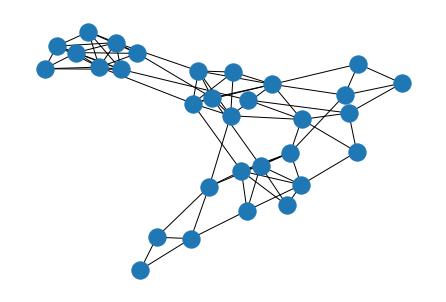

In [31]:
# Plotting G without county-based coloring
np.random.seed(1)

nx.draw(G)
plt.show()

In [32]:
# Comparing computed flow to random simulations
np.random.seed(0)

flow_matrix = transition_matrix @ transition_matrix

simulated_flow_matrix = np.zeros((31, 31))
num_simulations = 10000
for town_i in range(31):
  for _ in range(num_simulations):
    town_j = np.random.choice(G[town_i])
    town_k = np.random.choice(G[town_j])
    simulated_flow_matrix[town_k][town_i] += 1

simulated_flow_matrix /= num_simulations
# Ensures that our simulated frequencies closely resemble the directly computed flow
assert np.allclose(flow_matrix, simulated_flow_matrix, atol=1e-2)

In [33]:
# Comparing intra- and inter-county flow distributions
def compare_flow_distributions():
  county_flows = []
  between_county_flows = []
  for i in range(31):
    county = G.nodes[i]["county_id"]
    # We only iterate over nonzero rows in column i
    nonzero_indices = np.nonzero(flow_matrix[:, i])[0]
    for j in nonzero_indices:
      flow = flow_matrix[j][i]
      # Checks if two towns are in the same county
      if county == G.nodes[j]["county_id"]:
        county_flows.append(flow)
      else:
        between_county_flows.append(flow)
  
  mean_intra_flow = np.mean(county_flows)
  mean_inter_flow = np.mean(between_county_flows)
  print(f"Mean flow within a county: {mean_intra_flow:.3f}")
  print(f"Mean flow between different counties: {mean_inter_flow:.3f}")

  # Tracks all inter-county flows that are below the minimum intra-county flows
  threshold = min(county_flows)
  num_below = len([flow for flow in between_county_flows if flow < threshold])
  print(f"The minimum intra-county flow is approximately: {threshold:.3f}")
  print(f"{num_below} inter-county flows fall below that threshold.")

  plt.hist(county_flows, bins="auto", alpha=0.5, label="Intra-County Flow")
  plt.hist(between_county_flows, bins="auto", alpha=0.5, label="Inter-County Flow")
  plt.axvline(threshold, linestyle="--", color="k", label="Intra-County Threshold")
  plt.legend()
  plt.show()

Mean flow within a county: 0.116
Mean flow between different counties: 0.042
The minimum intra-county flow is approximately: 0.042
132 inter-county flows fall below that threshold.


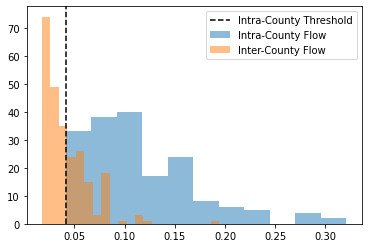

In [34]:
compare_flow_distributions()

In [35]:
# Decreasing the separation threshold
num_below = np.count_nonzero((flow_matrix > 0.0) & (flow_matrix < 0.01))
print(f"{num_below} inter-county flows fall below a threshold of 0.01.")

0 inter-county flows fall below a threshold of 0.01.


In [36]:
# Exaggerating value differences through vector inflation
v = np.array([0.7, 0.3])

v2 = v ** 2
v2 /= v2.sum()

assert v.mean() == round(v2.mean(), 10)
assert v2[0] > v[0]
assert v2[1] < v[1]

Mean flow within a county: 0.146
Mean flow between different counties: 0.020
The minimum intra-county flow is approximately: 0.012
118 inter-county flows fall below that threshold.


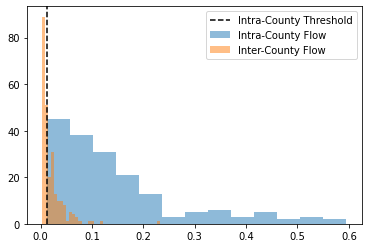

In [37]:
# Exaggerating flow differences through vector inflation
def inflate(matrix):
  matrix = matrix ** 2
  return matrix / matrix.sum(axis=0)

flow_matrix = inflate(flow_matrix)
compare_flow_distributions()

Mean flow within a county: 0.159
Mean flow between different counties: 0.004
The minimum intra-county flow is approximately: 0.001
541 inter-county flows fall below that threshold.


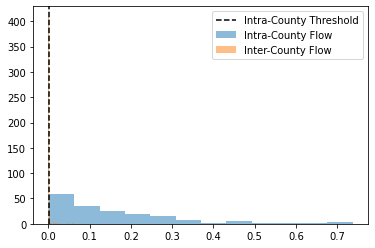

In [38]:
# Inflating the product of flow_matrix with itself
flow_matrix = inflate(flow_matrix @ flow_matrix)
compare_flow_distributions()

In [39]:
# Inflating the product of flow_matrix repeatedly with itself
for _ in range(20):
  flow_matrix = inflate(flow_matrix @ flow_matrix)

In [40]:
# Selecting suspected inter-county edges
suspected_inter_county = [(i, j) for (i, j) in G.edges() if not (flow_matrix[i][j] or flow_matrix[j][i])]
num_suspected = len(suspected_inter_county)
print(f"We suspect {num_suspected} edges of appearing between counties.")

We suspect 57 edges of appearing between counties.


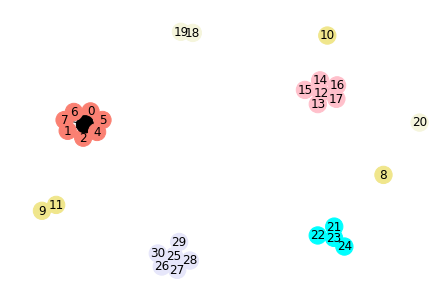

In [41]:
# Deleting suspected inter-county edges
np.random.seed(1)

G_copy = G.copy()
G_copy.remove_edges_from(suspected_inter_county)

nx.draw(G_copy, with_labels=True, node_color=node_colors)
plt.show()

In [42]:
# Improving flow by adding self-loops
def compute_flow(adjacency_matrix):
  transaction_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
  return (transaction_matrix @ transaction_matrix)[1][0]

M1 = np.array([
  [0, 1], [1, 0]
])
M2 = np.array([
  [1, 1], [1, 1]
])

flow1, flow2 = [compute_flow(M) for M in [M1, M2]]
print(f"The flow from A to B without self-loops is {flow1}")
print(f"The flow from A to B with self-loops is {flow2}")

The flow from A to B without self-loops is 0.0
The flow from A to B with self-loops is 0.5


In [43]:
# Defining an MCL function
def run_mcl(G):
  for i in G.nodes:
    # Adds self-loops to each node in the graph
    G.add_edge(i, i)

  adjacency_matrix = nx.to_numpy_array(G)
  transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
  flow_matrix = inflate(transition_matrix @ transition_matrix)

  for _ in range(20):
    flow_matrix = inflate(flow_matrix @ flow_matrix)

  G.remove_edges_from([(i, j) for i, j in G.edges() if not (flow_matrix[i][j] or flow_matrix[j][i])])

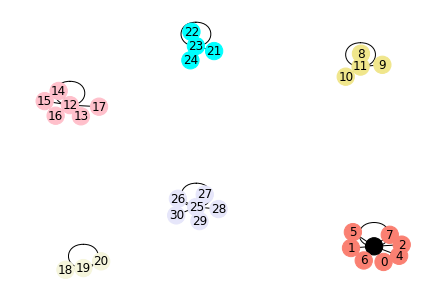

In [44]:
G_copy = G.copy()
run_mcl(G_copy)
nx.draw(G_copy, with_labels=True, node_color=node_colors)
plt.show()

In
graph theory, such isolated clusters are referred to as connected components: two nodes
are in the same connected component if a path exists between them.

Otherwise, the
nodes exist in different components (and thus in different communities).

In [45]:
# Using path lengths to uncover a county cluster
component = nx.shortest_path_length(G_copy, source=0).keys()
county_id = G.nodes[0]["county_id"]

for i in component:
  assert G.nodes[i]["county_id"] == county_id

print(f"The following towns are found in County {county_id}:")
print(sorted(component))

The following towns are found in County 0:
[0, 1, 2, 3, 4, 5, 6, 7]


In [46]:
# Extracting all the clustered connected components
for component in nx.connected_components(G_copy):
  county_id = G.nodes[list(component)[0]]["county_id"]
  print(f"\nThe following towns are found in County {county_id}:")
  print(component)


The following towns are found in County 0:
{0, 1, 2, 3, 4, 5, 6, 7}

The following towns are found in County 1:
{8, 9, 10, 11}

The following towns are found in County 2:
{12, 13, 14, 15, 16, 17}

The following towns are found in County 3:
{18, 19, 20}

The following towns are found in County 4:
{24, 21, 22, 23}

The following towns are found in County 5:
{25, 26, 27, 28, 29, 30}


Unfortunately, our MCL implementation will not scale to very large networks. 

Further optimizations are required for successful scaling; these optimizations have been
integrated into the external Markov clustering library.

In [52]:
from markov_clustering import get_clusters, run_mcl

In [53]:
# Clustering with the Markov clustering library
adjacency_matrix = nx.to_numpy_array(G)
clusters = get_clusters(run_mcl(adjacency_matrix))

for cluster in clusters:
  county_id = G.nodes[cluster[0]]['county_id']
  print(f"\nThe following towns are found in County {county_id}:")
  print(cluster)


The following towns are found in County 0:
(0, 1, 2, 3, 4, 5, 6, 7)

The following towns are found in County 1:
(8, 9, 10, 11)

The following towns are found in County 2:
(12, 13, 14, 15, 16, 17)

The following towns are found in County 3:
(18, 19, 20)

The following towns are found in County 4:
(21, 22, 23, 24)

The following towns are found in County 5:
(25, 26, 27, 28, 29, 30)


With Markov clustering, we can detect communities in community-structured graphs.

This will prove useful when we search for groups of friends in social networks.

##Uncovering friend groups in social networks

We can represent many processes as networks, including relationships between people. Within these **social networks**, nodes represent individual people. 

One famous social network is called _Zachery’s Karate Club_. That network can be loaded from `NetworkX`.

In [54]:
# Loading the karate club graph
G_karate = nx.karate_club_graph()
print(G_karate.nodes(data=True))

[(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'}), (3, {'club': 'Mr. Hi'}), (4, {'club': 'Mr. Hi'}), (5, {'club': 'Mr. Hi'}), (6, {'club': 'Mr. Hi'}), (7, {'club': 'Mr. Hi'}), (8, {'club': 'Mr. Hi'}), (9, {'club': 'Officer'}), (10, {'club': 'Mr. Hi'}), (11, {'club': 'Mr. Hi'}), (12, {'club': 'Mr. Hi'}), (13, {'club': 'Mr. Hi'}), (14, {'club': 'Officer'}), (15, {'club': 'Officer'}), (16, {'club': 'Mr. Hi'}), (17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'}), (21, {'club': 'Mr. Hi'}), (22, {'club': 'Officer'}), (23, {'club': 'Officer'}), (24, {'club': 'Officer'}), (25, {'club': 'Officer'}), (26, {'club': 'Officer'}), (27, {'club': 'Officer'}), (28, {'club': 'Officer'}), (29, {'club': 'Officer'}), (30, {'club': 'Officer'}), (31, {'club': 'Officer'}), (32, {'club': 'Officer'}), (33, {'club': 'Officer'})]


Our nodes track 34 people. Each node has a `club` attribute. That attribute is set to _Mr. Hi_ if the person joined Mr. Hi’s karate club. Otherwise, it’s set to _Officer_.  

Lets go ahead and visualize the network.

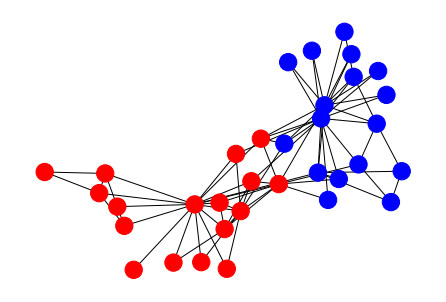

In [56]:
# Visualizing the Karate Club graph
np.random.seed(2)

club_to_color = {"Mr. Hi": "r", "Officer": "b"}
node_colors = [club_to_color[G_karate.nodes[i]["club"]] for i in G_karate]
nx.draw(G_karate, node_color=node_colors)
plt.show()

The Karate Club graph has a clear community structure. The colored clusters represent existing friend-groups. 

Lets extract these clusters using MCL.

In [57]:
# Clustering the Karate Club graph
adjacency_matrix = nx.to_numpy_array(G_karate)
clusters = get_clusters(run_mcl(adjacency_matrix))
for i, cluster in enumerate(clusters):
  print(f"Cluster {i}:\n {cluster}\n")

Cluster 0:
 (0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21)

Cluster 1:
 (2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33)



Two clusters have been outputted as expected. We’ll now re-plot the graph, while coloring each node by cluster id.

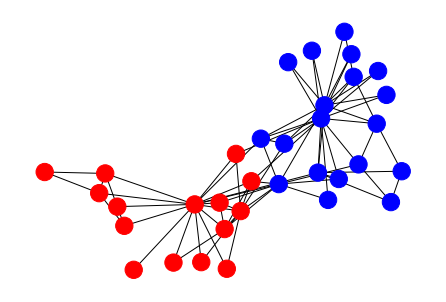

In [58]:
# Coloring the plotted graph by cluster
np.random.seed(2)

cluster_0, cluster_1 = clusters
node_colors = ["r" if i in cluster_0 else "b" for i in G_karate]
nx.draw(G_karate, node_color=node_colors)
plt.show()

Our clusters are nearly identical to the two splintered clubs. MCL has capably extracted the friend groups in the social network. 

The code below will illustrate how to color friend-groups in an automated manner.

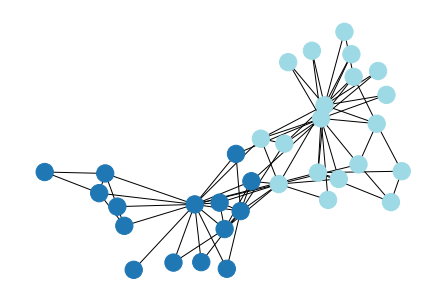

In [59]:
# Coloring social graph clusters automatically
np.random.seed(2)

for cluster_id, node_indices in enumerate(clusters):
  for i in node_indices:
    G_karate.nodes[i]["cluster_id"] = cluster_id

node_colors = [G_karate.nodes[n]['cluster_id'] for n in G_karate.nodes]
nx.draw(G_karate, node_color=node_colors, cmap=plt.cm.tab20)
plt.show()

We’ve completed our deep dive into graph theory.

In the next notebook, we use our
newfound knowledge to derive a simple, graph-based prediction algorithm.